In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import Libraries
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Amazon closing prices data
amzn_df = yf.download("AMZN", start="2011-01-01", end="2021-05-31")
amzn_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


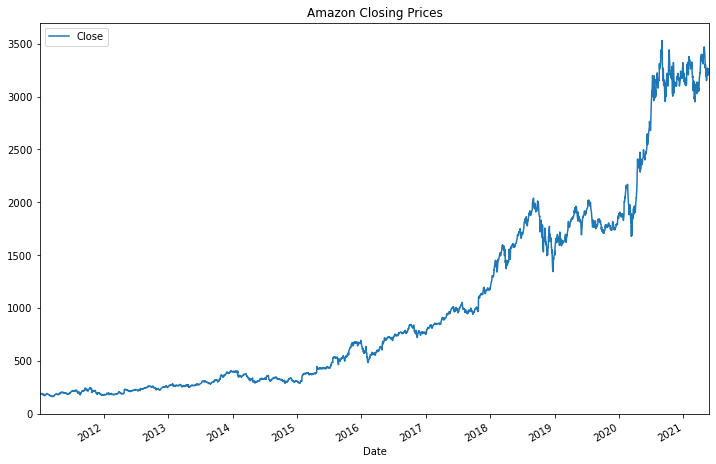

In [3]:
# Plot just the "Close" column from the dataframe:
amzn_df['Close'].plot(
    title='Amazon Closing Prices', 
    legend='Close', 
    figsize=(12, 8))
plt.margins(x=0)

From the above graph, we observe an upward trend in the long-term. The above time series plot also suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1. 

### Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the Close price into a trend and noise.

In [4]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
amzn_close_noise, amzn_close_trend = sm.tsa.filters.hpfilter(amzn_df['Close'])

In [5]:
# Create a dataframe of just the close price, and add columns for "noise" and "trend" series from above:
amzn_price_df = pd.DataFrame(amzn_df['Close'])
amzn_price_df['noise'] = amzn_close_noise
amzn_price_df['trend'] = amzn_close_trend
amzn_price_df.head()

,Close,noise,trend
Date,,,
2011-01-03,184.220001,-2.331156,186.551157
2011-01-04,185.009995,-1.164021,186.174016
2011-01-05,187.419998,1.624581,185.795417
2011-01-06,185.860001,0.446823,185.413177
2011-01-07,185.490005,0.463878,185.026127


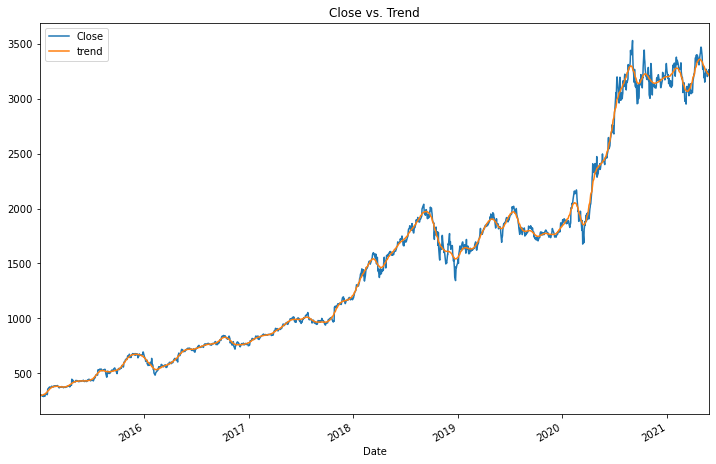

In [6]:
# Plot the Close Price vs. the Trend for 2011 to the present
close_price_2011_to_present = amzn_price_df['Close'].loc['2011-01-01':]
trend_2011_to_present = amzn_price_df['trend'].loc['2015-01-01':]

close_price_vs_trend_2011_to_present = pd.concat(
    [close_price_2011_to_present, trend_2011_to_present],
    axis="columns", 
    join="inner"
    )
close_price_vs_trend_2011_to_present.plot(
    title='Close vs. Trend', 
    legend=['Close', 'trend'],
    figsize=(12, 8)
)
plt.margins(x=0)

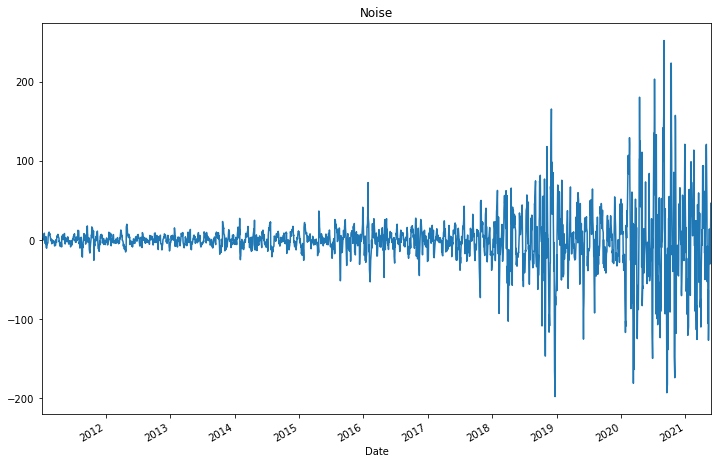

In [7]:
# Plot the Close Noise
amzn_close_noise.plot(title='Noise', figsize=(12, 8))
plt.margins(x=0)

### Autocorrelation and Partial Autocorrelation Analysis

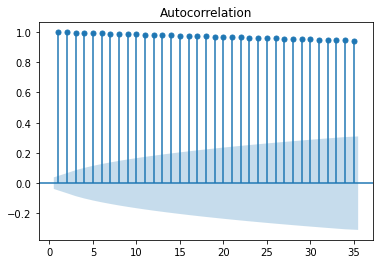

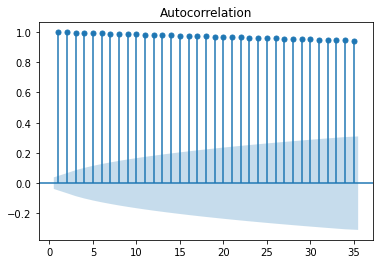

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation of the Settle Prices
plot_acf(amzn_df.Close, zero=False, lags=35)

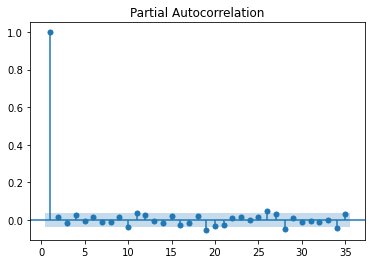

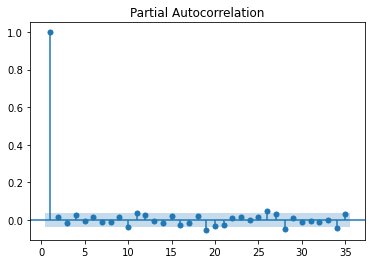

In [9]:
# Plot the partial autocorrelation 
plot_pacf(amzn_df.Close, zero=False, lags=35)

### Forecasting the Close Price using an ARIMA Model
Using the Close Price, estimate an ARIMA model.
Set P=1, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(1,1,1))
P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

In [10]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
amzn_close_price = amzn_df[['Close']]
amzn_close_price = amzn_close_price.replace(-np.inf, np.nan).dropna()
                               
arima_model = ARIMA(amzn_close_price.Close, order=(1,1,1))

# Fit the model
arima_results = arima_model.fit()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
# Print the model summary
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2618
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12327.888
Method:                       css-mle   S.D. of innovations             26.842
Date:                Tue, 01 Jun 2021   AIC                          24663.776
Time:                        15:05:35   BIC                          24687.257
Sample:                             1   HQIC                         24672.281
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1606      0.507      2.289      0.022       0.167       2.154
ar.L1.D.Close    -0.6199      0.110     -5.660      0.000      -0.835      -0.405
ma.L1.D.Close     0.5658      0.114      4.948      0.000       0.342       0.790
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6131           +0.0000j            1.6131            0.5000
MA.1           -1.7674           +0.0000j            1.7674            0.5000
-----------------------------------------------------------------------------
"""

We have an ARIMA model and the parameters that we have set are p=1, d=1 and q=1.

From the above summary table, the model is ARIMA(1,1,1) and the p-values of the lags are:

constant has p-value 0.022.
ar.L1.D.Close, here L1 represents the particular lag 1 that our model is using and the autoregressive term has p-value 0.000.
ma.L1.D.Close, here L1 represents the particular lag 1 that our model is using and the moving average term has p-value 0.000.
Based on the p-values, we observe that all the above p-values are less than the significance level (0.05). From this, we conclude that the ARIMA(1,1,1) model is a good fit.

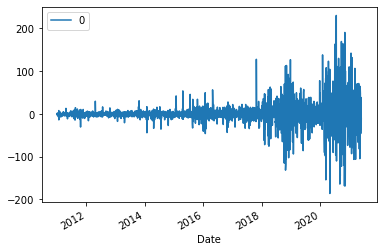

In [12]:
# line plot of residuals
residuals = DataFrame(arima_results.resid)
residuals.plot()
plt.show()

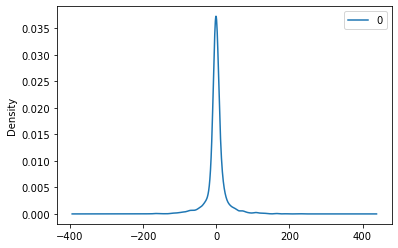

In [13]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [14]:
# summary stats of residuals
print(residuals.describe())

                 0
count  2618.000000
mean     -0.000094
std      26.846797
min    -186.096578
25%      -5.515246
50%      -0.511243
75%       5.565375
max     230.204244


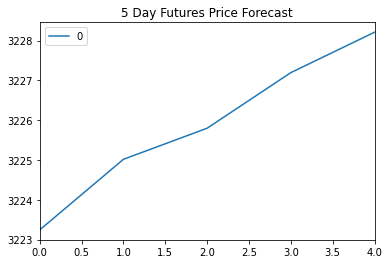

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")
plt.margins(x=0)

Above we used the entire dataset for time series analysis.

Now, we will perform the analysis on just the training dataset when developing a predictive model.
Next, let’s look at how we can use the ARIMA model to make forecasts.

### Rolling Forecast ARIMA Model

In [16]:
amzn_df.shape

(2619, 6)

In [17]:
# Split the data set into a training and testing 
# Create a train/test split for the data using 2020-2021 for testing and the rest for training
train = amzn_df[:'2018']
test = amzn_df['2019':]

In [18]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100
2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600
2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600
2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200
2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


In [19]:
print(train.shape,test.shape)

(2012, 6) (607, 6)


In [36]:
amzn_close_price2 = train['Close'].replace(-np.inf, np.nan).dropna()
arima_model2 = ARIMA(amzn_close_price2,order=(1,1,1))
arima_results2 = arima_model2.fit()
arima_results2.summary()

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2011
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8331.513
Method:                       css-mle   S.D. of innovations             15.242
Date:                Tue, 01 Jun 2021   AIC                          16671.026
Time:                        15:09:41   BIC                          16693.451
Sample:                             1   HQIC                         16679.258
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6549      0.288      2.275      0.023       0.091       1.219
ar.L1.D.Close     0.8022      0.080     10.064      0.000       0.646       0.958
ma.L1.D.Close    -0.8325      0.073    -11.373      0.000      -0.976      -0.689
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2466           +0.0000j            1.2466            0.0000
MA.1            1.2011           +0.0000j            1.2011            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
start = len(train)
end = len(train)+len(test)-1
predictions = arima_results2.predict(start=start,end=end,typ='levels')
predictions

/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/soma/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2011    1502.392639
2012    1502.861249
2013    1503.366714
2014    1503.901744
2015    1504.460491
           ...     
2613    1895.720888
2614    1896.375822
2615    1897.030755
2616    1897.685689
2617    1898.340623
Length: 607, dtype: float64

In [38]:
test_pred_df = test.reset_index()[['Date', 'Close']]
test_pred_df['Actual'] = test_pred_df['Close'].rename('Close')
test_pred_df.drop(columns='Close', inplace=True)


In [39]:
test_pred_df['Predictions'] = predictions.reset_index().drop(columns='index')


In [40]:
test_pred_df = test_pred_df.set_index('Date')
test_pred_df


,Actual,Predictions
Date,,
2019-01-02,1539.130005,1502.392639
2019-01-03,1500.280029,1502.861249
2019-01-04,1575.390015,1503.366714
2019-01-07,1629.510010,1503.901744
2019-01-08,1656.579956,1504.460491
...,...,...
2021-05-24,3244.989990,1895.720888
2021-05-25,3259.050049,1896.375822
2021-05-26,3265.159912,1897.030755


<AxesSubplot:title={'center':'Actual vs. Prediction of Amazon Closing Price'}, xlabel='Date'>

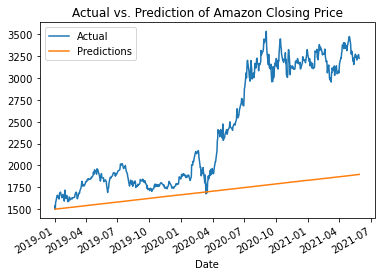

In [41]:
test_pred_df.plot(title='Actual vs. Prediction of Amazon Closing Price')


In [42]:
rmse = (((test_pred_df['Actual'] - test_pred_df['Predictions']) ** 2).mean()) ** 0.5
# print('Test Root Mean Squared Error: %.3f' % math.sqrt(error))

In [43]:
rmse

894.4142454188161